In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

In [380]:
# --- Load and Clean Data ---
# Load CSV file into DataFrame
saint_louis_df = pd.read_csv("AI-project-1-Saint-Louis-Crime-Data-In-Relation-to-Temperature-and-Weather/2021-2023.csv", low_memory=False)

crime_data = pd.read_csv("AI-project-1-Saint-Louis-Crime-Data-In-Relation-to-Temperature-and-Weather/2021-2023.csv", low_memory=False)


In [381]:
# Drop irrelevant columns
columns_to_drop = ['IncidentNum', 'NIBRS', 'NIBRSCategory', 'SRS_UCR', 'CrimeAgainst', 'FelMisdCit', 'IncidentTopSRS_UCR', 'District', 'Neighborhood', 'NbhdNum', 'Latitude', 'Longitude', 'IncidentSupplemented', 'LastSuppDate', 'VictimNum', 'FirearmUsed','IncidentNature',]
crime_data.drop(columns=columns_to_drop, inplace=True)


In [382]:
# Rename columns for consistency
crime_data.rename(columns={
    'IncidentDate': 'Date',
    'OccurredFromTime': 'Time',
    'Offense': 'CrimeType'
    
}, inplace=True)



In [383]:
# Convert 'Date' column to datetime format
crime_data['Date'] = pd.to_datetime(crime_data['Date'], errors='coerce')

In [384]:

# Filter data for 2021-2023 only
crime_data = crime_data[(crime_data['Date'].dt.year >= 2021) & (crime_data['Date'].dt.year <= 2023)]


In [385]:
# Handle missing or null values
crime_data.dropna(subset=['Date', 'CrimeType'], inplace=True)
crime_data

,Date,Time,CrimeType,IncidentLocation,IntersectionOtherLoc
0,2021-05-20,NaN,UNFOUNDED INCIDENT,NaN,NaN
1,2021-05-05,NaN,UNFOUNDED INCIDENT,NaN,NaN
7,2021-01-13,00:01:00,FAIL TO REGISTER AS A SEX OFFENDER PURSUANT TO...,1915 OLIVE ST,NaN
8,2023-08-28,00:10:00,STEALING - MOTOR VEHICLE/WATERCRAFT/AIRCRAFT &...,22ND STREET,MARKET STREET
11,2021-10-26,10:30:00,STEALING - MOTOR VEHICLE/WATERCRAFT/AIRCRAFT,LINDENWOOD,MACKLIND
...,...,...,...,...,...
180133,2023-12-17,13:00:00,ENDANGERING THE WELFARE OF A CHILD INVOLVING D...,5756 WOODLAND AVE,NaN
180134,2023-07-05,15:00:00,STEALING UNDER $150 (PETTY LARCENY-MOTOR VEH P...,4312 GRACE AVE,NaN
180135,2022-06-01,12:00:00,IDENTITY THEFT OR ATTEMPT,5304 WABADA AVE,B
180136,2023-11-20,12:00:00,STEALING UNDER $150 (PETTY LARCENY - FROM MOTO...,3611 MORGANFORD RD,NaN


In [386]:
#3. Feature Engineering 
# Extract year, month, day, and day of the week
crime_data['Year'] = crime_data['Date'].dt.year
crime_data['Month'] = crime_data['Date'].dt.month
crime_data['Day'] = crime_data['Date'].dt.day
crime_data['DayOfWeek'] = crime_data['Date'].dt.day_name()

print(crime_data['Date']. isnull().sum())



0


In [387]:
print(crime_data.head())

         Date      Time                                          CrimeType  \
0  2021-05-20       NaN                                 UNFOUNDED INCIDENT   
1  2021-05-05       NaN                                 UNFOUNDED INCIDENT   
7  2021-01-13  00:01:00  FAIL TO REGISTER AS A SEX OFFENDER PURSUANT TO...   
8  2023-08-28  00:10:00  STEALING - MOTOR VEHICLE/WATERCRAFT/AIRCRAFT &...   
11 2021-10-26  10:30:00       STEALING - MOTOR VEHICLE/WATERCRAFT/AIRCRAFT   

   IncidentLocation IntersectionOtherLoc  Year  Month  Day  DayOfWeek  
0               NaN                  NaN  2021      5   20   Thursday  
1               NaN                  NaN  2021      5    5  Wednesday  
7     1915 OLIVE ST                  NaN  2021      1   13  Wednesday  
8       22ND STREET        MARKET STREET  2023      8   28     Monday  
11       LINDENWOOD             MACKLIND  2021     10   26    Tuesday  


In [388]:
crime_data['Season'] = crime_data['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')


In [389]:
# Categorize time of day
crime_data['Time'] = pd.to_datetime(crime_data['Time'], errors='coerce').dt.hour
crime_data['TimeOfDay'] = crime_data['Time'].apply(lambda x: 'Morning' if 6 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Evening' if 18 <= x < 24 else 'Night')



/var/folders/lr/hp5n0nzs45n81kqx50cqt0xh0000gn/T/ipykernel_49899/277772805.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data['Time'] = pd.to_datetime(crime_data['Time'], errors='coerce').dt.hour


In [390]:
# --- 4. Exploratory Data Analysis (EDA) ---
# Print statistics and check value counts for key columns
print(crime_data.describe())
print(crime_data['Year'].value_counts())
print(crime_data['Season'].value_counts())
print(crime_data['TimeOfDay'].value_counts())

                             Date           Time           Year  \
count                      179094  177919.000000  179094.000000   
mean   2022-07-06 12:24:02.460384      13.215772    2022.001418   
min           2021-01-01 00:00:00       0.000000    2021.000000   
25%           2021-10-06 00:00:00       8.000000    2021.000000   
50%           2022-07-16 00:00:00      14.000000    2022.000000   
75%           2023-03-26 00:00:00      19.000000    2023.000000   
max           2023-12-31 00:00:00      23.000000    2023.000000   
std                           NaN       6.954544       0.809499   

               Month            Day  
count  179094.000000  179094.000000  
mean        6.659944      15.658124  
min         1.000000       1.000000  
25%         4.000000       8.000000  
50%         7.000000      16.000000  
75%        10.000000      23.000000  
max        12.000000      31.000000  
std         3.369760       8.854304  
Year
2022    61736
2023    58806
2021    58552
Name: c

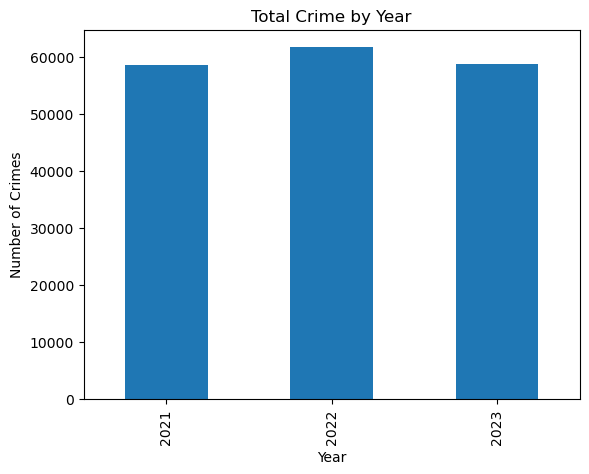

In [391]:
 #--- 5. Data Visualization ---
# 1. Crime Over Time
crime_by_year = crime_data.groupby('Year').size()
crime_by_year.plot(kind='bar', title='Total Crime by Year', xlabel='Year', ylabel='Number of Crimes')
plt.show()


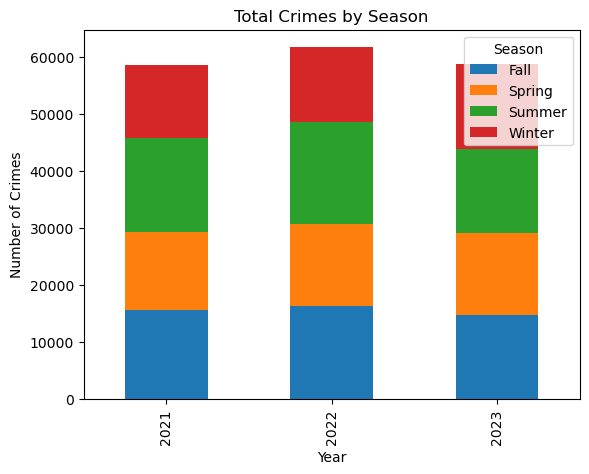

In [392]:
# 2. Seasonal Crime Analysis
seasonal_crime = crime_data.groupby(['Year', 'Season']).size().unstack()
seasonal_crime.plot(kind='bar', stacked=True, title='Total Crimes by Season', xlabel='Year', ylabel='Number of Crimes')
plt.show()

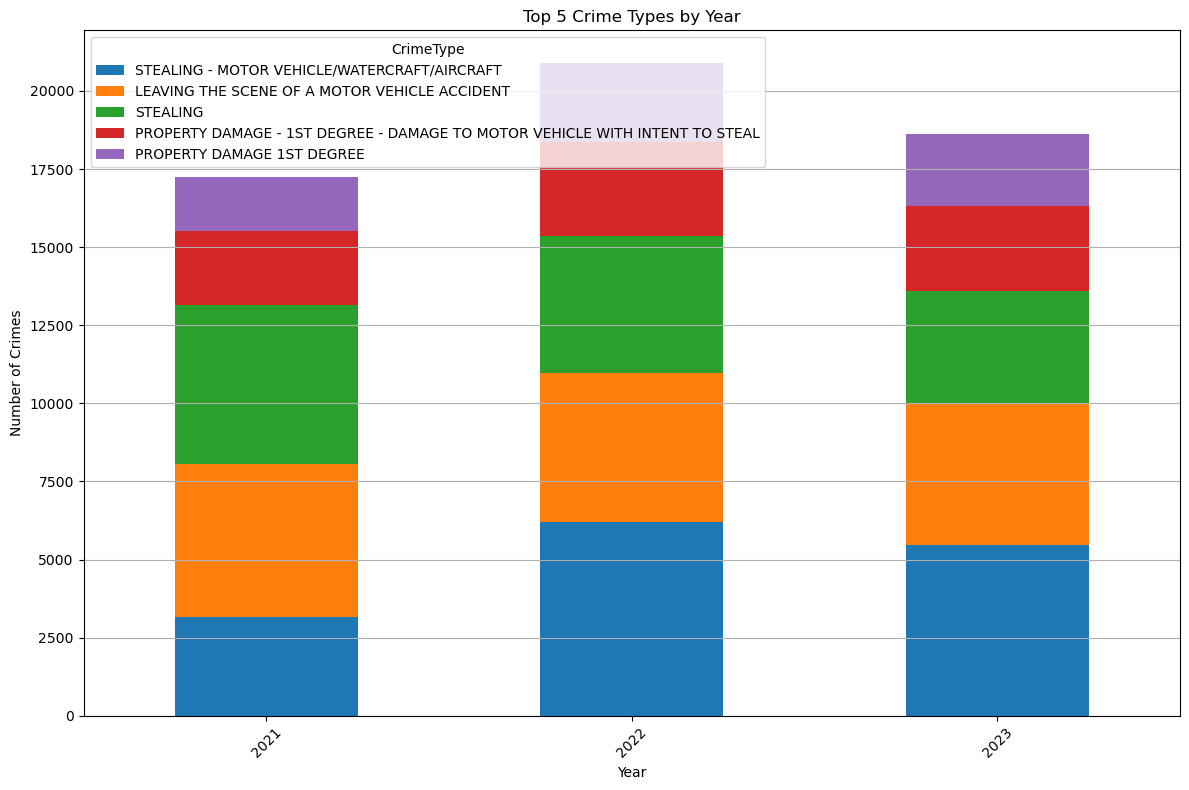

In [393]:
# Step 1: Group by Year and CrimeType, then count occurrences
crime_type_by_year = crime_data.groupby(['Year', 'CrimeType']).size().unstack(fill_value=0)

# Step 2: Sum occurrences of each crime type across all years and get the top 5
top_crime_types = crime_type_by_year.sum().nlargest(5).index
crime_type_by_year_top5 = crime_type_by_year[top_crime_types]

# Step 3: Plotting
crime_type_by_year_top5.plot(kind='bar', stacked=True, figsize=(12, 8),
                              title='Top 5 Crime Types by Year', xlabel='Year', ylabel='Number of Crimes')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(axis='y')  # Add grid for better readability
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


In [394]:
crime_data.columns

Index(['Date', 'Time', 'CrimeType', 'IncidentLocation', 'IntersectionOtherLoc',
       'Year', 'Month', 'Day', 'DayOfWeek', 'Season', 'TimeOfDay'],
      dtype='object')

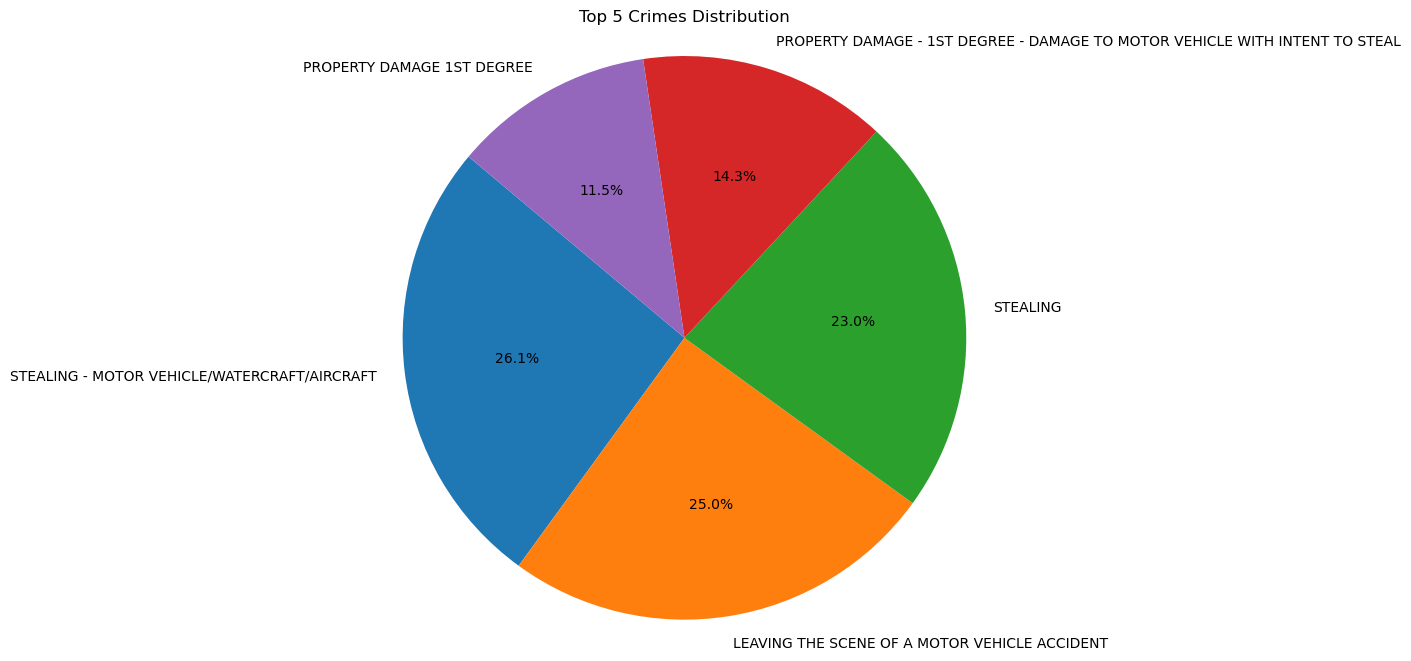

In [395]:
# Step 1: Count occurrences of each crime type
crime_counts = crime_data['CrimeType'].value_counts()

# Step 2: Select the top 5 crimes
top_crimes = crime_counts.nlargest(5)

# Step 3: Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Crimes Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

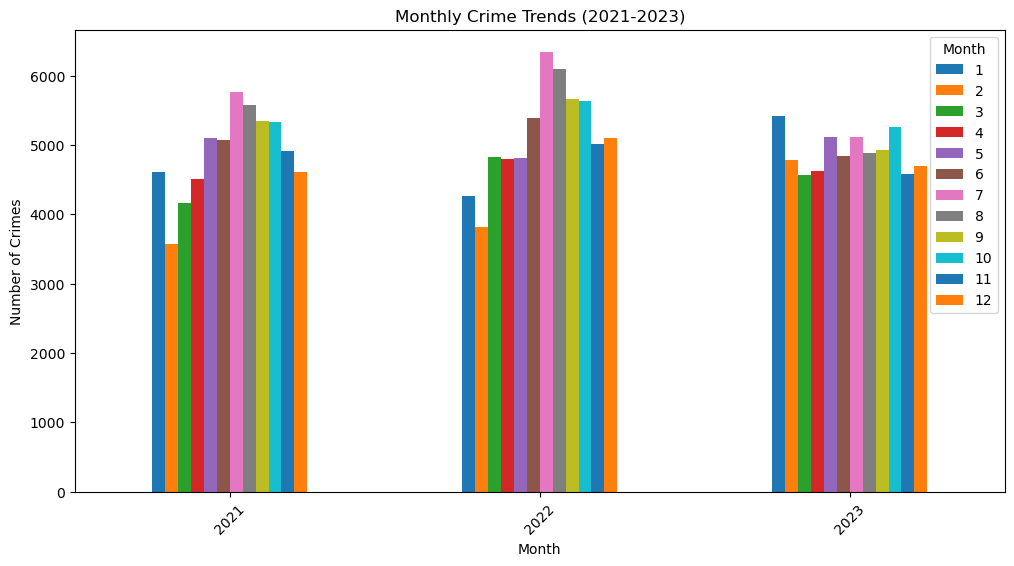

In [396]:
monthly_crime_trends = crime_data.groupby(['Year', 'Month']).size().unstack()

# Create a bar plot
monthly_crime_trends.plot(kind='bar', figsize=(12, 6), title='Monthly Crime Trends (2021-2023)', xlabel='Month', ylabel='Number of Crimes')

# Set x-tick labels to show month names if needed
plt.xticks(rotation=45)

plt.show()

<Figure size 1200x600 with 0 Axes>

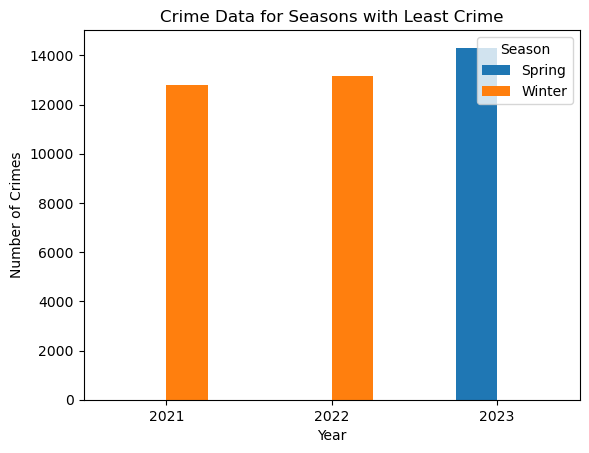

Season with the least crimes each year: Year
2021    Winter
2022    Winter
2023    Spring
dtype: object


In [397]:
season_with_least_crime = crime_data.groupby(['Year', 'Season']).size().groupby(level=0).idxmin()

# Extract the seasons with the least crime for each year
least_crime_seasons = season_with_least_crime.apply(lambda x: x[1])  # Get the season part from the tuple

# Convert the index to a list of tuples for filtering
least_crime_season_tuples = list(least_crime_seasons.items())

# Filter the original data for these seasons
filtered_data = crime_data[crime_data.set_index(['Year', 'Season']).index.isin(least_crime_season_tuples)]

# Create a bar plot for the filtered data
plt.figure(figsize=(12, 6))
filtered_data.groupby(['Year', 'Season']).size().unstack().plot(kind='bar', title='Crime Data for Seasons with Least Crime', xlabel='Year', ylabel='Number of Crimes')

# Show the plot
plt.xticks(rotation=0)
plt.show()

# Print the seasons with the least crimes
print("Season with the least crimes each year:", least_crime_seasons)

<Figure size 1200x600 with 0 Axes>

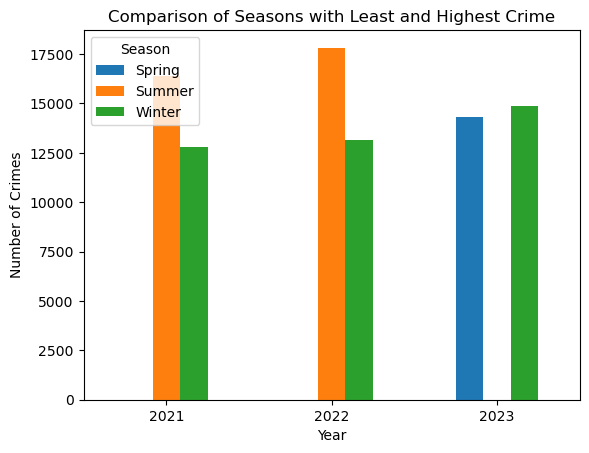

Season with the least crimes each year: Year
2021    Winter
2022    Winter
2023    Spring
dtype: object
Season with the highest crimes each year: Year
2021    Summer
2022    Summer
2023    Winter
dtype: object


In [398]:
# Group by Year and Season, then find the season with the least and highest crimes each year
season_with_least_crime = crime_data.groupby(['Year', 'Season']).size().groupby(level=0).idxmin()
season_with_highest_crime = crime_data.groupby(['Year', 'Season']).size().groupby(level=0).idxmax()

# Extract the seasons
least_crime_seasons = season_with_least_crime.apply(lambda x: x[1])  # Get the season part from the tuple
highest_crime_seasons = season_with_highest_crime.apply(lambda x: x[1])  # Get the season part from the tuple

# Convert the index to a list of tuples for filtering
least_crime_season_tuples = list(least_crime_seasons.items())
highest_crime_season_tuples = list(highest_crime_seasons.items())

# Filter the original data for these seasons
filtered_least_crime = crime_data[crime_data.set_index(['Year', 'Season']).index.isin(least_crime_season_tuples)]
filtered_highest_crime = crime_data[crime_data.set_index(['Year', 'Season']).index.isin(highest_crime_season_tuples)]

# Combine the filtered data into a single DataFrame
combined_filtered_data = pd.concat([filtered_least_crime, filtered_highest_crime])

# Create a bar plot for the filtered data
plt.figure(figsize=(12, 6))
combined_filtered_data.groupby(['Year', 'Season']).size().unstack().plot(kind='bar', title='Comparison of Seasons with Least and Highest Crime', xlabel='Year', ylabel='Number of Crimes')

# Show the plot
plt.xticks(rotation=0)
plt.legend(title='Season')
plt.show()

# Print the seasons with the least and highest crimes
print("Season with the least crimes each year:", least_crime_seasons)
print("Season with the highest crimes each year:", highest_crime_seasons)

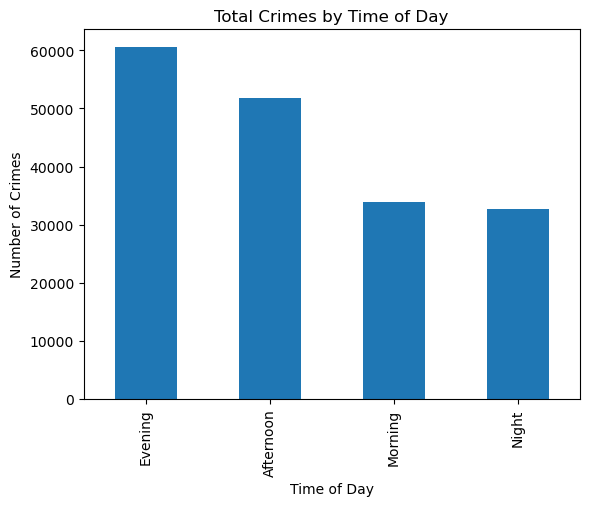

In [399]:
# 8. Crime by Time of Day
crime_by_time_of_day = crime_data['TimeOfDay'].value_counts()
crime_by_time_of_day.plot(kind='bar', title='Total Crimes by Time of Day', xlabel='Time of Day', ylabel='Number of Crimes')
plt.show()

In [400]:
# --- 6. Statistical Analysis ---
# Test for seasonality


seasonal_crime_counts = [
    crime_data[crime_data['Season'] == 'Winter'].shape[0],
    crime_data[crime_data['Season'] == 'Spring'].shape[0],
    crime_data[crime_data['Season'] == 'Summer'].shape[0],
    crime_data[crime_data['Season'] == 'Fall'].shape[0]
]

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for season, count in zip(seasons, seasonal_crime_counts):
    print(f"Number of crimes in {season}: {count}")

Number of crimes in Winter: 40850
Number of crimes in Spring: 42519
Number of crimes in Summer: 49075
Number of crimes in Fall: 46650


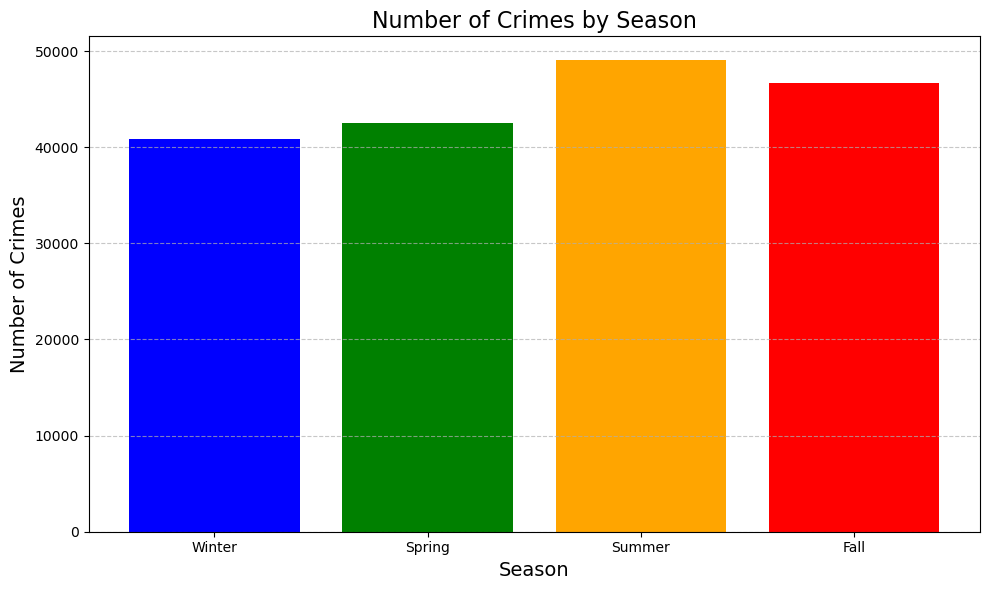

In [401]:
# List of seasons
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# Create a bar plot for seasonal crime counts
plt.figure(figsize=(10, 6))
plt.bar(seasons, seasonal_crime_counts, color=['blue', 'green', 'orange', 'red'])

# Add title and labels
plt.title('Number of Crimes by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)

# Show the plot
plt.xticks(rotation=0)  # Rotate x-tick labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

Trend Line Slope: 126.99999999999973


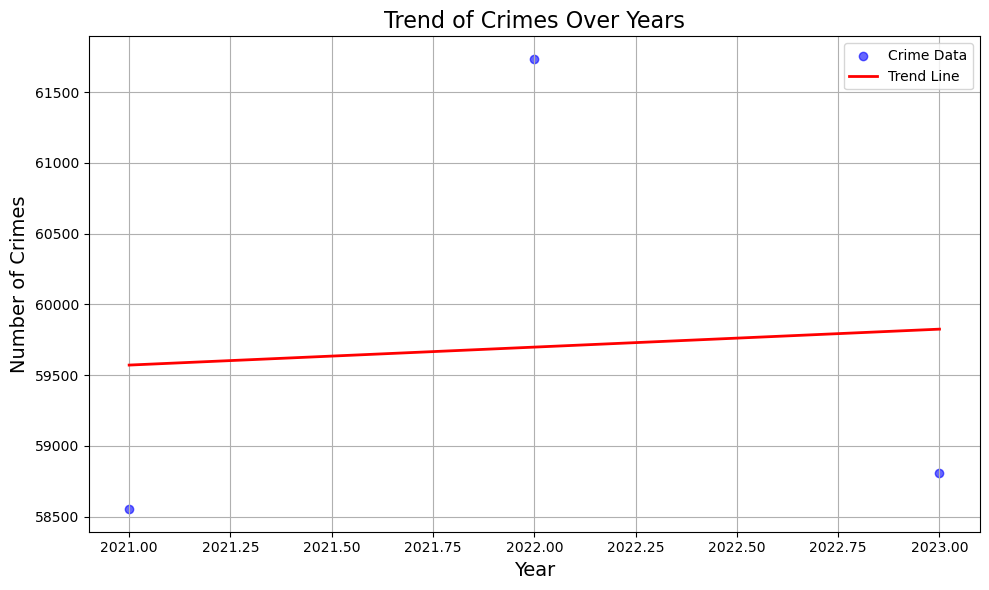

In [402]:
# Prepare the data for linear regression
# Group by Year and count the number of crimes
crime_years = crime_data.groupby('Year').size().reset_index()

x = crime_years['Year'].values.reshape(-1, 1)  # Reshape for sklearn
y = crime_years[0].values

# Perform linear regression
reg = LinearRegression().fit(x, y)

# Output the trend line slope
print("Trend Line Slope:", reg.coef_[0])  # Print the slope of the trend line

# Visualize the data and the trend line
plt.figure(figsize=(10, 6))
plt.scatter(crime_years['Year'], y, color='blue', label='Crime Data', alpha=0.6)
plt.plot(crime_years['Year'], reg.predict(x), color='red', label='Trend Line', linewidth=2)

# Add title and labels
plt.title('Trend of Crimes Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

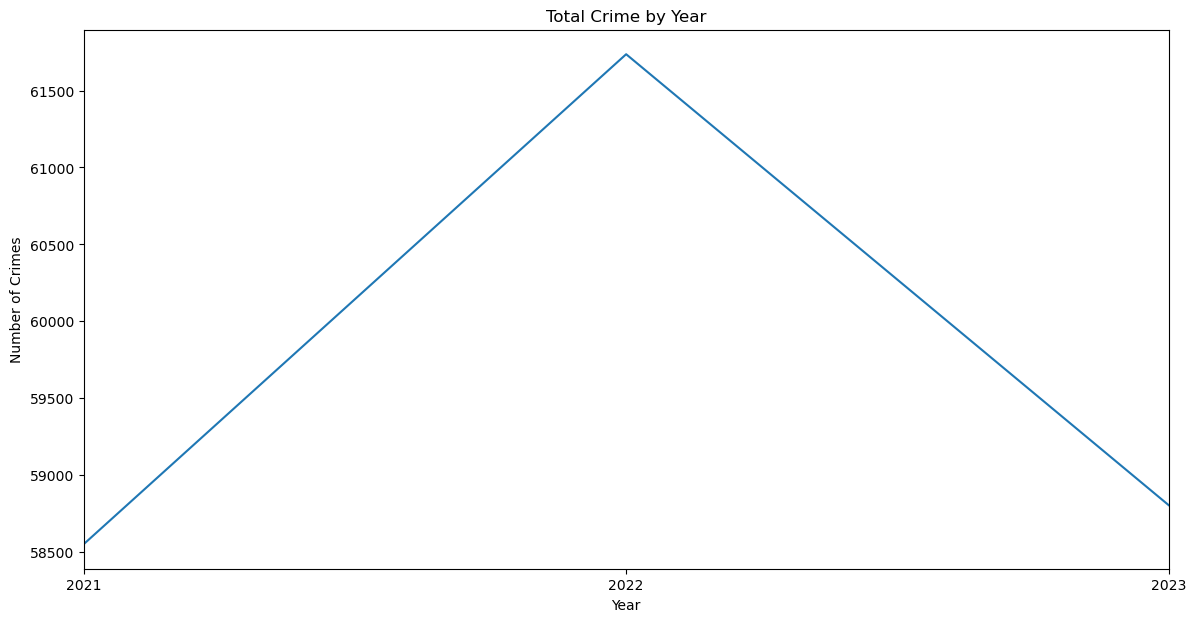

In [405]:
# Group by Year and count the number of crimes
crime_by_year = crime_data.groupby('Year').size()

# Create a line plot for total crime by year
plt.figure(figsize=(14, 7))  # Set the figure size to be bigger
crime_by_year.plot(kind='line', title='Total Crime by Year', xlabel='Year', ylabel='Number of Crimes')

# Set the x-ticks to show each year
plt.xticks(crime_by_year.index, rotation=0)  # Set x-ticks to be the years

# Optionally, you can set the limits of the x-axis if needed
plt.xlim(crime_by_year.index.min(), crime_by_year.index.max())

# Save the plot as an image
plt.savefig('total_crime_by_year.png')

# Optionally, show the plot
plt.show()
